In [1]:
import os
import sys
import time
import argparse
import numpy as np
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import pandas as pd
from torch.utils.data import DataLoader
from models.efficientdet import EfficientDet
from models.losses import FocalLoss
from datasets import Spine_dataset, get_augumentation, detection_collate
from utils import EFFICIENTDET
from tqdm import tqdm_notebook as tqdm
import cv2
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed):
#     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(24)

In [3]:
resume = None#'./weights/d4-resize-(1536,512)-skull.pth'
network = 'efficientdet-d4'
num_epochs = 60
batch_size = 1
num_worker = 4
num_classes = 1
device = [0]
grad_accumulation_steps = 1
learning_rate = 1e-4
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
save_folder = 'weights/'
image_root = 'boostnet_labeldata/data/'
csv_root = 'boostnet_labeldata/labels/'

In [4]:
if not os.path.exists(save_folder):
    os.mkdir(save_folder)

In [5]:
def prepare_device(device):
    n_gpu_use = len(device)
    n_gpu = torch.cuda.device_count()
    if n_gpu_use > 0 and n_gpu == 0:
        print("Warning: There\'s no GPU available on this machine, training will be performed on CPU.")
        n_gpu_use = 0
    if n_gpu_use > n_gpu:
        print("Warning: The number of GPU\'s configured to use is {}, but only {} are available on this machine.".format(
            n_gpu_use, n_gpu))
        n_gpu_use = n_gpu
    list_ids = device
    device = torch.device('cuda:{}'.format(
        device[0]) if n_gpu_use > 0 else 'cpu')

    return device, list_ids

In [6]:
def get_state_dict(model):
    if type(model) == torch.nn.DataParallel:
        state_dict = model.module.state_dict()
    else:
        state_dict = model.state_dict()
    return state_dict

In [7]:
checkpoint = []
if(resume is not None):
    resume_path = str(resume)
    print("Loading checkpoint: {} ...".format(resume_path))
    checkpoint = torch.load(
        resume, map_location=lambda storage, loc: storage)
    num_classes = checkpoint['num_class']
    network = checkpoint['network']

In [8]:
corner_df_train = pd.read_csv(csv_root+'training/landmarks.csv',header = None)
filename_df_train = pd.read_csv(csv_root+'training/filenames.csv',header = None)
boxes_df_train = pd.read_csv(csv_root+'training/train.csv')
boxes_df_train.label = 0 # All boxes same class??

In [9]:
corner_df_test = pd.read_csv(csv_root+'test/landmarks.csv',header = None)
filename_df_test = pd.read_csv(csv_root+'test/filenames.csv',header = None)
boxes_df_test = pd.read_csv('test.csv')
boxes_df_test.label = 0

In [10]:
train_dataset = Spine_dataset.SPINEDetection(image_root,boxes_df_train,filename_df_train,transform=get_augumentation('train'))

In [11]:
val_dataset = Spine_dataset.SPINEDetection(image_root,boxes_df_test,filename_df_test,transform=get_augumentation('val'),image_set='test')

In [12]:
test_dataset = Spine_dataset.SPINEDetection_test(transform=get_augumentation('test'))

In [13]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              num_workers=num_worker,
                              shuffle=True,
                              collate_fn=detection_collate,
                              pin_memory=True)

In [14]:
val_dataloader = DataLoader(val_dataset,
                              batch_size=batch_size,
                              num_workers=num_worker,
                              shuffle=False,
                              collate_fn=detection_collate,
                              pin_memory=True)

In [15]:
test_dataloader = DataLoader(test_dataset,
                              batch_size=batch_size,
                              num_workers=num_worker,
                              shuffle=False,
                              collate_fn=None,
                              pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([1, 3, 1792, 640]) torch.Size([1, 17, 5])


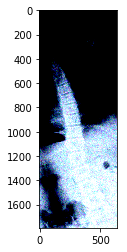

In [16]:
for idx, (images, annotations) in enumerate(train_dataloader):
    print(idx ,images.shape, annotations.shape)
    plt.imshow(images[0].permute(1,2,0))
    break

In [17]:
model = EfficientDet(num_classes=num_classes,
                     network=network,
                     W_bifpn=EFFICIENTDET[network]['W_bifpn'],
                     D_bifpn=EFFICIENTDET[network]['D_bifpn'],
                     D_class=EFFICIENTDET[network]['D_class'],
                     )

Loaded pretrained weights for efficientnet-b4


In [18]:
if(resume is not None):
    model.load_state_dict(checkpoint['state_dict'])
device, device_ids = prepare_device(device)
model = model.to(device)
if(len(device_ids) > 1):
    model = torch.nn.DataParallel(model, device_ids=device_ids)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=3, verbose=True)
criterion = FocalLoss()

In [ ]:
model.train()
best_loss = 100
df = pd.DataFrame(np.zeros((num_epochs,4)),columns = ["train_cls","train_bbox_loss","val_cls","val_bbox_loss"])
for epoch in range(num_epochs):
    print("{} epoch: \t start training....".format(epoch))
    
    start = time.time()
    result = {}
    total_loss = []
    bbox_losses = []
    cls_losses = []
    corner_losses = []
    optimizer.zero_grad()
    total_batches = len(train_dataloader)
    tk0 = tqdm(train_dataloader, total=total_batches)
    for idx, (images, annotations_bboxes) in enumerate(tk0):
        images = images.to(device)
        annotations_bboxes = annotations_bboxes.to(device)
        classification, regression, anchors = model(images)
        classification_loss, regression_loss= criterion(
            classification, regression, anchors, annotations_bboxes)
#         print(classification_loss)
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()
        loss = classification_loss + regression_loss
        if bool(loss == 0):
            print('loss equal zero(0)')
            continue
        loss.backward()
        if (idx+1) % grad_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            optimizer.zero_grad()
        total_loss.append(loss.item())
        bbox_losses.append(regression_loss.item())
        cls_losses.append(classification_loss.item())
        tk0.set_postfix(loss=(np.mean(total_loss)))
    result = {
        'time': time.time() - start,
        'loss': np.mean(total_loss),
        'bbox_loss': np.mean(bbox_losses),
        'cls_loss': np.mean(cls_losses)
    }
    for key, value in result.items():
        print('    {:15s}: {}'.format(str(key), value))
    df.iloc[epoch,:2] = [np.mean(cls_losses),np.mean(bbox_losses)] 
    torch.cuda.empty_cache()
    with torch.no_grad():
        start = time.time()
        result = {}
        total_loss = []
        bbox_losses = []
        cls_losses = []
        optimizer.zero_grad()
        total_batches = len(test_dataloader)
        tk0 = tqdm(val_dataloader, total=total_batches)
        for idx, (images, annotations_bboxes) in enumerate(tk0):
            images = images.to(device)
            annotations_bboxes = annotations_bboxes.to(device)
            classification, regression, anchors = model(images)
            classification_loss, regression_loss = criterion(
                classification, regression, anchors, annotations_bboxes)
            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()
            loss = classification_loss + regression_loss
            if bool(loss == 0):
                print('loss equal zero(0)')
                continue
            total_loss.append(loss.item())
            bbox_losses.append(regression_loss.item())
            cls_losses.append(classification_loss.item())
            tk0.set_postfix(loss=(np.mean(total_loss)))
        result = {
            'time': time.time() - start,
            'loss': np.mean(total_loss),
            'bbox_loss': np.mean(bbox_losses),
            'cls_loss': np.mean(cls_losses)
        }
        for key, value in result.items():
            print('    {:15s}: {}'.format(str(key), value))
            
    scheduler.step(np.mean(total_loss))
    df.iloc[epoch,2:] = [np.mean(cls_losses),np.mean(bbox_losses)]
    df.to_csv('../logs/d4-downsample-(1920,640)-skull.csv')
    torch.cuda.empty_cache()
    arch = type(model).__name__
    state = {
        'arch': arch,
        'num_class': num_classes,
        'network': network,
        'state_dict': get_state_dict(model)
    }
    if best_loss>np.mean(bbox_losses):
        best_loss = np.mean(bbox_losses)
        torch.save(
            state, './weights/d4-downsample-(1920,640)-skull.pth')

0 epoch: 	 start training....


/home/arnav0400/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



    time           : 397.7654929161072
    loss           : 3.74854224362641
    bbox_loss      : 0.9932429075488926
    cls_loss       : 2.755299260735264


/home/arnav0400/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



    time           : 26.652674913406372
    loss           : 1.3364402065053582
    bbox_loss      : 0.868584644049406
    cls_loss       : 0.4678555566351861
1 epoch: 	 start training....



    time           : 393.2411513328552
    loss           : 1.212871859326432
    bbox_loss      : 0.8303522675795764
    cls_loss       : 0.38251959236644656



    time           : 26.34661841392517
    loss           : 1.0635545649565756
    bbox_loss      : 0.7621536459773779
    cls_loss       : 0.3014009213075042
2 epoch: 	 start training....


In [27]:
model.is_training = False
model.threshold = 0.45

In [28]:
def vis(dataloader,split = 'test'):
    if split=='test':
        for idx, (images) in enumerate(dataloader):
            images = images.to(device)
            image = images[0]
            classification_score, category, boxes = model(images)
            break
    else:
        for idx, (images, annotations) in enumerate(dataloader):
            image = images[0]
            images = images.to(device)
            classification_score, category, boxes = model(images)
            break
    boxes = boxes.detach().cpu().numpy()
    image = image.detach().cpu().numpy()
    image = image.transpose(1,2,0)
    boxes = boxes.astype(np.int16)
    for box in boxes:
        start = (box[0],box[1])
        end = (box[2],box[3])
        image = cv2.rectangle(image, start, end, (255,0,0), 10)
#     plt.scatter(corners[:,:4],corners[:,4:])
    plt.imshow(image.get())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


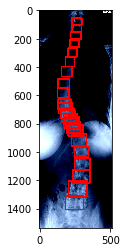

In [29]:
vis(val_dataloader,'a')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


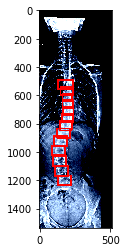

In [30]:
vis(test_dataloader)

In [31]:
def get_boxes(dataloader,split = 'test'):
    all_boxes = []
    all_scores = []
    if split=='test':
        for idx, (images) in enumerate(dataloader):
            images = images.to(device)
            image = images[0]
            classification_score, category, boxes = model(images)
            classification_score = classification_score.detach().cpu().numpy()
            boxes = boxes.detach().cpu().numpy()
            boxes = boxes.astype(np.int16)
            all_boxes.append(boxes)
            all_scores.append(classification_score)
    else:
        for idx, (images, annotations) in tqdm(enumerate(dataloader)):
            image = images[0]
            images = images.to(device)
            classification_score, category, boxes = model(images)
            boxes = boxes.detach().cpu().numpy()
            classification_score = classification_score.detach().cpu().numpy()
            boxes = boxes.astype(np.int16)
            all_boxes.append(boxes)
            all_scores.append(classification_score)
    return all_boxes,all_scores

In [32]:
test_boxes, test_scores = get_boxes(test_dataloader)

In [33]:
for i in range(len(test_boxes)):
    print(test_boxes[i].shape)

(13, 4)
(18, 4)
(16, 4)
(18, 4)
(18, 4)
(16, 4)
(16, 4)
(18, 4)
(13, 4)
(13, 4)
(8, 4)
(18, 4)
(17, 4)
(12, 4)
(15, 4)
(17, 4)
(6, 4)
(12, 4)
(5, 4)
(14, 4)
(12, 4)
(14, 4)
(19, 4)
(18, 4)
(19, 4)
(12, 4)
(17, 4)
(17, 4)
(8, 4)
(16, 4)
(9, 4)
(8, 4)
(5, 4)
(12, 4)
(18, 4)
(18, 4)
(9, 4)
(14, 4)
(19, 4)
(19, 4)
(19, 4)
(11, 4)
(16, 4)
(18, 4)
(14, 4)
(18, 4)
(11, 4)
(11, 4)
(20, 4)
(9, 4)
(14, 4)
(20, 4)
(17, 4)
(10, 4)
(10, 4)
(13, 4)
(14, 4)
(3, 4)
(16, 4)
(12, 4)
(18, 4)
(13, 4)
(12, 4)
(8, 4)
(10, 4)
(16, 4)
(18, 4)
(17, 4)
(17, 4)
(18, 4)
(21, 4)
(9, 4)
(3, 4)
(18, 4)
(8, 4)
(19, 4)
(15, 4)
(9, 4)
(4, 4)
(19, 4)
(19, 4)
(19, 4)
(20, 4)
(18, 4)
(16, 4)
(19, 4)
(13, 4)
(17, 4)
(14, 4)
(10, 4)
(20, 4)
(19, 4)
(17, 4)
(18, 4)
(4, 4)
(11, 4)
(19, 4)
(19, 4)


In [34]:
import pickle
with open("boxes_d4_skull-0.45.txt", "wb") as fp:   #Pickling
    pickle.dump(test_boxes, fp)
with open("scores_d4_skull-0.45.txt", "wb") as fp:   #Pickling
    pickle.dump(test_scores, fp)

In [ ]:
def get_predictions(dataloader = val_dataloader):
    corners = []
    clipped_corners = []
    
    # Predictions from model
    for idx, (image, annotation, corner) in enumerate(val_dataloader):
        image = image.to(device)
        classification_score, category, pred_boxes, pred_corner = model(image)
        classification_score = classification_score.detach().cpu().numpy()
        pred_corner = pred_corner.detach().cpu().numpy()
        if classification_score.shape[0]>17:
            ind = np.argpartition(classification_score, -17)[-17:]
            corners.append(pred_corner[ind])
        else:
            corners.append(pred_corner)
    
    #Making all predictions 17
    for corner in corners:
        if corner.shape[0]==17:
            clipped_corners.append(corner)
        else:
            num_repeat = 17-corner.shape[0]
            repeat = corner[-1].reshape(1,8)
            for i in range(num_repeat):
                corner = np.append(corner,repeat,axis=0)
            clipped_corners.append(corner)
    
    clipped_corners = np.array(clipped_corners)
    
    #Reshaping and saving csv
    val_landmarks = np.zeros((len(clipped_corners),136))
    for i in range(len(clipped_corners)):
        val_landmarks[i,:68] = clipped_corners[i,:,:4].reshape(1,68)/768
        val_landmarks[i,68:] = clipped_corners[i,:,4:].reshape(1,68)/1408
    
    val_preds = pd.DataFrame(val_landmarks)
    val_preds.to_csv('val_preds.csv',header = None,index = False)
    return val_preds

In [ ]:
get_predictions()

In [41]:
import numpy as np
import pandas as pd

## find the SMAPE error
def smape(y_true, y_pred):
    numerator = np.sum(np.abs(y_true-y_pred), axis=1)
    denominator = np.sum(np.abs(y_true+y_pred), axis=1)
    smape_val = np.mean(numerator/ denominator) * 100
    return smape_val



true_csv_path = "test_angles_gt_h.csv"
pred_csv_path = "test_angles.csv"
true_angles = pd.read_csv(true_csv_path, header=None).values
pred_angles = pd.read_csv(pred_csv_path, header=None).values
print (smape(true_angles, pred_angles))

23.70854861509844
